### Exploration of the watermass transformations taking place in a simple re-entrant box with linear vertical diffusion

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt

In [2]:
## LOAD DATA
vgrid = 'native'
averaging = '6h'

# Time-mean tendencies
rootdir = '/archive/gam/MOM6-gm/ocean_only/box/dev_core/'+averaging+'/'
filename = 'ocean_'+vgrid+'.nc'
ds = xr.open_dataset(rootdir+filename)
# Time steps
delta_t = ds['average_DT'].astype('timedelta64[s]')
# Grid
filename_grid = 'ocean_static.nc'
grid = xr.open_dataset(rootdir+filename_grid)
# Constants
cp = 3992.0
rho0 = 1035.0

# Snapshots
filename_snap = 'ocean_'+vgrid+'_snap.nc'
ds_snap = xr.open_dataset(rootdir+filename_snap)

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
# Calculate budget closure
# Budget terms
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']

# HEAT
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

#### Evolution of water column over time

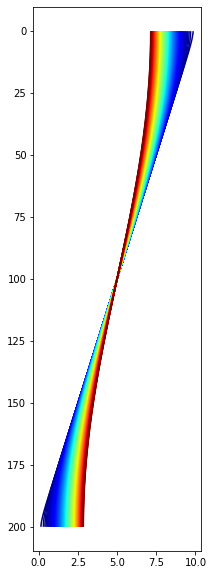

In [4]:
prof = ds.isel(xh=10,yh=10)
nt = len(prof['time'])
colors = plt.cm.jet(np.linspace(0,1,nt))
fig,ax = plt.subplots(figsize=(3,10))
for i in range(nt):
    ax.plot(prof['temp'].isel(time=i),prof['zl'],color=colors[i]);
ax.invert_yaxis()

## Look at spatial information for one contour

In [5]:
nt = len(ds['time'])
l = ds['temp'][{'time':slice(1,nt)}]
dls = ds[heat_terms[3:]][{'time':slice(1,nt)}]/rho0/cp
l_snap = ds_snap['temp']
volume_snap = ds_snap['thkcello']*grid.areacello

l_l = 8
delta_l = 0.1
l_i_above = l_l+delta_l/2
l_i_below = l_l-delta_l/2
mask_E = (l>=l_i_below) & (l<l_i_above)
mask_Psnap = l_snap>l_l
in_E = xr.ones_like(l).where(mask_E,0)
dls_in_E = dls['opottempdiff'].where(mask_E,0)
in_Psnap = xr.ones_like(l_snap).where(mask_Psnap,0)

# One timestep
t=20

#### Visualize contour and volume

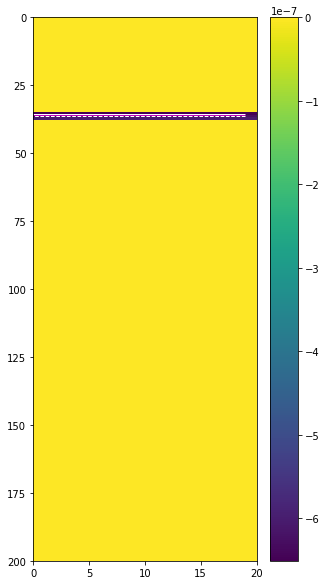

In [6]:
fig,ax0 = plt.subplots(figsize=(5,10))
im = ax0.pcolormesh(dls_in_E.isel(time=t,yh=0).squeeze())
ax0.contour(in_Psnap.isel(time=t,yh=0).squeeze(),levels=np.array([0.5]),colors='w',linewidths=1,linestyles='--')
ax0.contour(in_Psnap.isel(time=t+1,yh=0).squeeze(),levels=np.array([0.5]),colors='w',linewidths=1)
ax0.contour(l.isel(time=t,yh=0).squeeze(),levels=np.array([l_l]),colors='m',linewidths=1)
ax0.invert_yaxis()
plt.colorbar(im,ax=ax0)
# ax1.plot(l.isel(time=t,yh=0,xh=0).squeeze())
# ax1.plot(in_E.isel(time=t,yh=0,xh=0).squeeze())

## Calculate water mass transformation across temperature surfaces

#### Calculation

In [7]:
nt = len(ds['time'])
l = ds['temp'][{'time':slice(1,nt)}]
dls = ds[heat_terms[3:]][{'time':slice(1,nt)}]/rho0/cp
l_i_vals = np.arange(-1,11,0.1)
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])

weight_dl = grid.areacello
c = rho0
ps = rho0*ds['boundary_forcing_h_tendency'][{'time':slice(1,nt)}].to_dataset()
weight_p = grid.areacello
dims = ['xh','yh','zl']
greaterthan = True
dim_time='time'

l_snap = ds_snap['temp']
volume_snap = ds_snap['thkcello']*grid.areacello

new_time = l['time']

# dMdt
dMdt = wmt.calc_dPdt(l=l_snap,p=rho0,l_l_vals=l_l_vals,weight=volume_snap,new_time=new_time)
# E
E = wmt.calc_E_wrapper(l=l, dls=dls, l_i_vals=l_i_vals, c=c, weight=weight_dl)
# E total
E_tot = xr.zeros_like(E['boundary_forcing_heat_tendency'])
for var in E.data_vars:
    E_tot += E[var]
E_tot.name = 'E_tot'
# P
P = wmt.calc_P_wrapper(l=l, ps=ps, l_l_vals=l_l_vals, weight=weight_p, greaterthan=greaterthan)
P_tot = xr.zeros_like(P['boundary_forcing_h_tendency'])
for var in P.data_vars:
    P_tot += P[var]
# Residual
residual = dMdt - E_tot - P_tot

#### One timestep

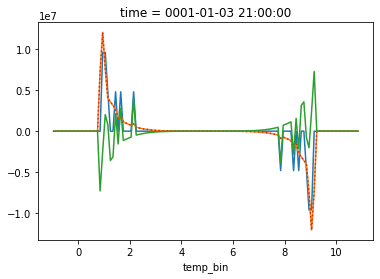

In [8]:
t = 10
dMdt.isel(time=t).plot()
E_tot.isel(time=t).plot(color='tab:orange')
E['opottempdiff'].isel(time=t).plot(linestyle=':',color='tab:red')
residual.isel(time=t).plot(color='tab:green')

#### Time-mean

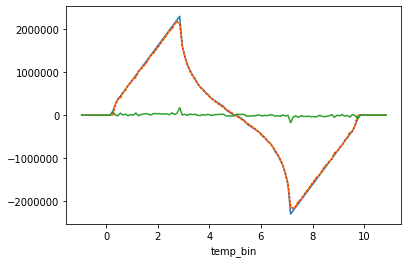

In [9]:
residual = dMdt - E_tot
dMdt.mean('time').plot()
E_tot.mean('time').plot(color='tab:orange')
E['opottempdiff'].mean('time').plot(linestyle=':',color='tab:red')
residual.mean('time').plot(color='tab:green')

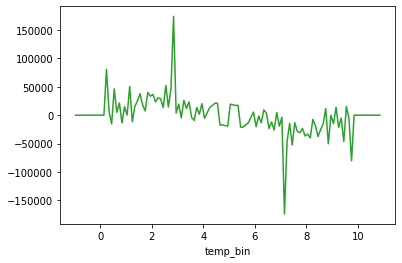

In [10]:
residual.mean('time').plot(color='tab:green')

#### All data

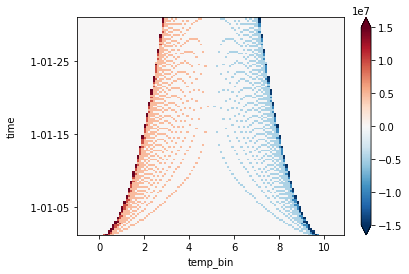

In [11]:
dMdt.plot(vmin=-1.5E7, vmax=1.5E7, cmap='RdBu_r')

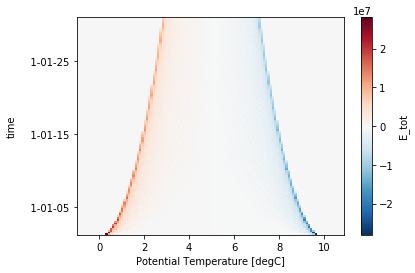

In [12]:
E_tot.plot()

#### Evolution of residual over time

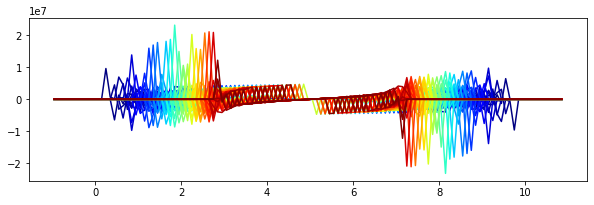

In [13]:
nt = len(residual['time'])
colors = plt.cm.jet(np.linspace(0,1,nt))
fig,ax = plt.subplots(figsize=(10,3))
for i in range(nt):
    ax.plot(residual[l.name+'_bin'],residual.isel(time=i),color=colors[i]);

## Calculate internal heat content budget

#### Calculation

In [114]:
# Internal heat content budget
nt = len(ds['time'])
l = ds['temp'][{'time':slice(1,nt)}]
delta_l = 0.5
l_i_vals = np.arange(-1,11,delta_l)
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])

ps = ds[heat_terms[3:]][{'time':slice(1,nt)}]/cp
weight_p = grid.areacello
dims = ['xh','yh','zl']
greaterthan = True
dim_time='time'

l_snap = ds_snap['temp']
volume_snap = ds_snap['thkcello']*grid.areacello

new_time = l['time']

# Internal heat content change
dLdt = wmt.calc_dPdt(l=l_snap,p=rho0*l_snap,l_l_vals=l_l_vals,weight=volume_snap,new_time=new_time)
dVdt = wmt.calc_dPdt(l=l_snap,p=1,l_l_vals=l_l_vals,weight=volume_snap,new_time=new_time)
dLidt = (dLdt-rho0*dVdt*dVdt[l.name+'_bin'])
# Internal processes
P = wmt.calc_P_wrapper(l=l, ps=ps, l_l_vals=l_l_vals, weight=weight_p, greaterthan=greaterthan)
# Residual
residual = dLidt.copy()
for var in P.data_vars:
    residual -= P[var]

#### One timestep

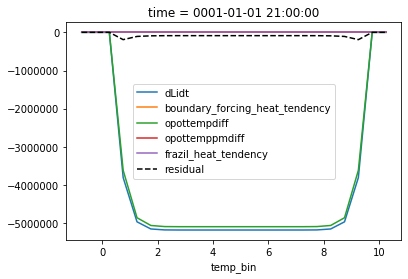

In [116]:
t=5
dLidt.isel(time=2).plot(label='dLidt')
for var in P.data_vars:
    P[var].isel(time=2).plot(label=var)
residual.isel(time=2).plot(linestyle='--',color='k', label='residual')
plt.legend()

#### Time-mean

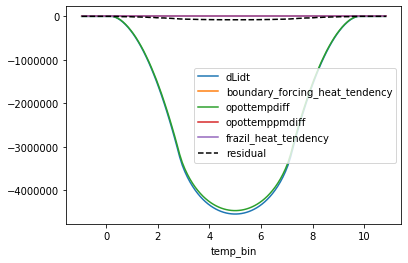

In [16]:
dLidt.mean('time').plot(label='dLidt')
for var in P.data_vars:
    P[var].mean('time').plot(label=var)
residual.mean('time').plot(linestyle='--',color='k', label='residual')
plt.legend()

#### All data

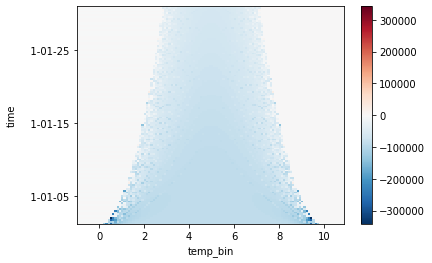

In [17]:
residual.plot()

## Consider how things look with linearly remapped vertical coordinates

In [291]:
from xarrayutils import vertical_coordinates as vc

# Time-mean fields

nt = len(ds['time'])
l = ds['temp'][{'time':slice(1,nt)}]
h = ds['thkcello'][{'time':slice(1,nt)}]

ps = (ds[heat_terms[4]][{'time':slice(1,nt)}]).to_dataset()/cp

# Get the depth of the layers on the native grid
z_i = xr.concat([xr.zeros_like(h.isel(zl=0)),h.cumsum(dim='zl')],dim='zl')
z_i = z_i.rename({'zl':'zi'})
z_i_vals = z_i.values
z_l_vals = 0.5*(z_i_vals[:,:,:,:-1]+z_i_vals[:,:,:,1:])
z_l = xr.DataArray(z_l_vals,dims=['time','yh','xh','zl'],coords={'time':l['time'],'xh':l['xh'],'yh':l['yh'],'zl':l['zl']})

delta_l = 0.05
l_i_vals = np.arange(-1,11,delta_l)
l_l_vals = 0.5*(l_i_vals[:-1]+l_i_vals[1:])

# Snapshots

l_snap = ds_snap['temp']
h_snap = ds_snap['thkcello']

# Get the depth of the layers on the native grid
z_snap_i = xr.concat([xr.zeros_like(h_snap.isel(zl=0)),h_snap.cumsum(dim='zl')],dim='zl')
z_snap_i = z_snap_i.rename({'zl':'zi'})
z_snap_i_vals = z_snap_i.values
z_snap_l_vals = 0.5*(z_snap_i_vals[:,:,:,:-1]+z_snap_i_vals[:,:,:,1:])
z_snap_l = xr.DataArray(z_snap_l_vals,dims=['time','yh','xh','zl'],coords={'time':z_snap_i.time,'xh':z_snap_i.xh,'yh':z_snap_i.yh,'zl':l['zl']})

In [292]:
### Time-mean fields ###

# Flip the order of the temperature bins
l_i = np.flip(l_i_vals)
l_i = xr.DataArray(l_i,coords={l.name+'_bin':l_i},dims=l.name+'_bin')

# Get depths of target temperature surfaces
print('time-mean')
l_i_depth = vc.linear_interpolation_regrid(z = z_l,
                                           data = l,
                                           target_values = l_i,
                                           z_bounds = z_i,
                                           target_value_dim = l.name+'_bin',
                                           z_bounds_dim='zi',
                                           z_dim='zl')

### Snapshots ###
# Flip the order of the temperature bins
l_i = np.flip(l_l_vals)
l_i = xr.DataArray(l_i,coords={l.name+'_bin':l_i},dims=l.name+'_bin')
print('snapshot')
l_snap_i_depth = vc.linear_interpolation_regrid(z = z_snap_l,
                                           data = l_snap,
                                           target_values = l_i,
                                           z_bounds = z_snap_i,
                                           target_value_dim = l.name+'_bin',
                                           z_bounds_dim='zi',
                                           z_dim='zl')

time-mean
snapshot


In [293]:
# Get the heat tendencies in temperature space
# A little hacky to recover vertically integrated quantities (as opposed to layer mean quantities as is currently output by vc algorithm)
# 1. Convert tendency to pseudo-intensive quantity
# 2. Conservative remap
# 3. Muliply by new layer thickness
ps_remap=xr.Dataset()
for term in ps.data_vars:
    print(term)
    dz_orig = z_i.diff('zi').rename({'zi':'zl'})
    ps_intensive = ps[term]/dz_orig
    ps_intensive_remapped = vc.conservative_remap(data=ps_intensive,z_bnds_source=z_i, z_bnds_target=l_i_depth,
                                   z_dim='zl', z_bnd_dim='zi', z_bnd_dim_target='regridded', mask=True)
    dz_targ = l_i_depth.diff('regridded').rename({'regridded':'remapped'})
    ps_remap[term] = ps_intensive_remapped*dz_targ

opottempdiff


#### Watermass transformation

In [294]:
# Watermass transformation
E = (ps_remap['opottempdiff']*grid.areacello).sum(['xh','yh'])/delta_l
E = E.assign_coords(remapped=np.flip(l_l_vals))
E = E.rename({'remapped':l.name+'_bin'})
# Volume change over time
# We can calculate the volume change in time from the change in interface depth
dVdt = (rho0*l_snap_i_depth*grid.areacello).sum(['xh','yh']).diff('time')/(6*60*60)
dVdt = dVdt.rename({'regridded':l.name+'_bin'}).assign_coords(time=E['time'])
# Residual
residual = dVdt-E

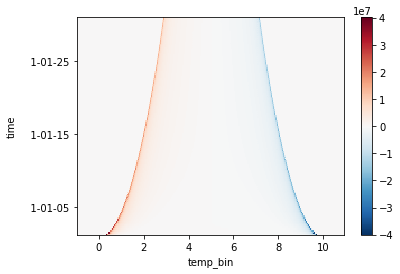

In [295]:
E.plot()

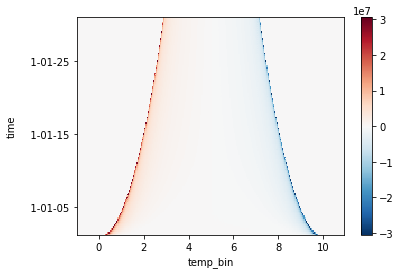

In [296]:
dVdt.plot()

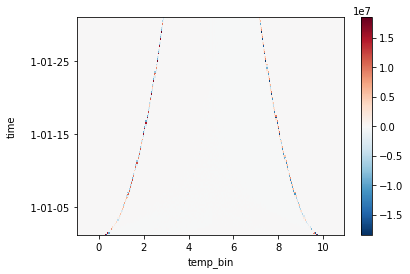

In [297]:
residual.plot()

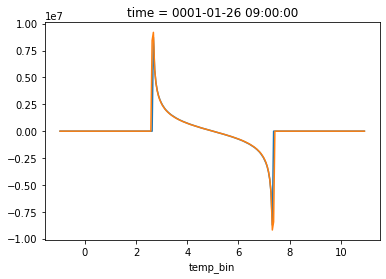

In [298]:
t=100
dVdt.isel(time=t).plot()
E.isel(time=t).plot()

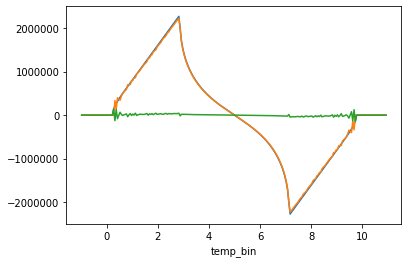

In [299]:
dVdt.mean('time').plot()
E.mean('time').plot()
residual.mean('time').plot()

#### Internal heat content

In [300]:
# Get depths of interfaces at snapshots
# Flip the order of the temperature bins
l_i = np.flip(l_i_vals)
l_i = xr.DataArray(l_i,coords={l.name+'_bin':l_i},dims=l.name+'_bin')
print('snapshot')
l_snap_i_depth = vc.linear_interpolation_regrid(z = z_snap_l,
                                           data = l_snap,
                                           target_values = l_i,
                                           z_bounds = z_snap_i,
                                           target_value_dim = l.name+'_bin',
                                           z_bounds_dim='zi',
                                           z_dim='zl')

snapshot


In [301]:
### Change in internal heat content over time
l_l = np.flip(l_l_vals)
l_l = xr.DataArray(l_l,coords={l_snap.name+'_bin':l_l},dims=l_snap.name+'_bin')
# Thicknesses of target grid
dz_targ = l_snap_i_depth.diff('regridded').rename({'regridded':l_snap.name+'_bin'}).assign_coords({l_snap.name+'_bin':l_l})
# Get vertically extensive temperature on the new grid (at the center-layer points)
lh_remap = (l_l*dz_targ)
# Get heat content (cumulatively summed from small l to large l) and volume change
dLdt = (rho0*lh_remap*grid.areacello).sum(['xh','yh']).cumsum(l_snap.name+'_bin').diff('time')/(6*60*60)
dVdt = (l_snap_i_depth*grid.areacello).rename({'regridded':l_snap.name+'_bin'}).sum(['xh','yh']).diff('time')/(6*60*60)
# Reassign l coords back to interfaces (following integration)
# Omit warmest temp because no integral beyond warmest interface
dLdt = dLdt.assign_coords({l_snap.name+'_bin':l_i[1:]})
# Difference gives internal heat content change
dLidt = (dLdt-rho0*dVdt*dVdt[l_snap.name+'_bin']).assign_coords(time=l['time'])

In [302]:
### Forcing
# Multiply by area, sum up in each layer, integrate
Ps = (ps_remap['opottempdiff']*grid.areacello).rename({'remapped':l.name+'_bin'}).sum(['xh','yh']).cumsum(l.name+'_bin')

In [303]:
residual = dLidt-Ps

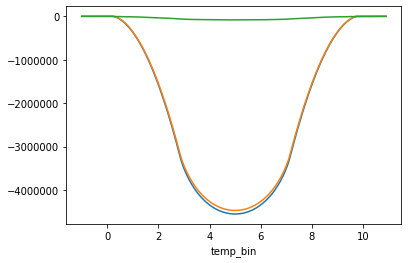

In [304]:
dLidt.mean('time').plot()
Ps.mean('time').plot()
residual.mean('time').plot()

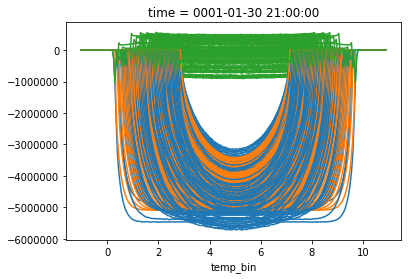

In [305]:
for t in range(len(residual['time'])):
    dLidt.isel(time=t).plot(color='tab:blue')
    Ps.isel(time=t).plot(color='tab:orange')
    residual.isel(time=t).plot(color='tab:green')

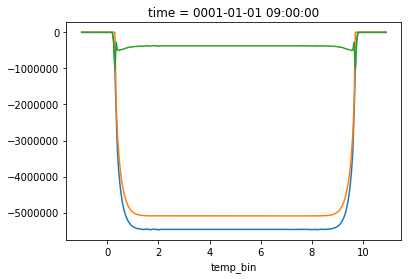

In [310]:
t=0
dLidt.isel(time=t).plot(color='tab:blue')
Ps.isel(time=t).plot(color='tab:orange')
residual.isel(time=t).plot(color='tab:green')

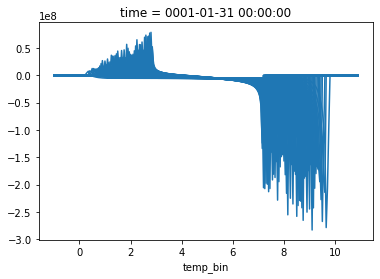

In [308]:
for t in range(len(residual['time'])):
    dLdt.isel(time=t).plot(color='tab:blue')
# (cp*rho0*dVdt[l_snap.name+'_bin']*dVdt).isel(time=t).plot()

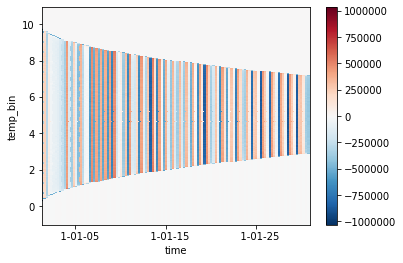

In [309]:
residual.plot()